In [1]:
# import statements
import utils
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Loading data

# Fake data
articles = np.asarray([
    ["Donald Trump buys a dog", "Donald Trump recently was found buying a dog"],
    ["President Trump gets a corgie", "The White House welcomes a new furry friend, and its name is Evan!"],
    ["U.S. Presidential Paws", "You won't believe the new dog that Donald and the fam just got!"],
    ["Biden sells his old car", "President Biden just announced that he is selling is '96 Civic"],
    ["President Biden to sell car", "Biden announced via Twitter that he will indeed be selling his car"],
    ["Biden getting that car cash", "Biden is about to cash out once he sells that junker civic!"]
])

In [3]:
# Vectorizing 
# Combining headlines and bodies
a = [x[0] + ': ' + x[1] for x in articles]
# Generating model 
roberta = SentenceTransformer('stsb-roberta-base')
v = utils.encode(a, roberta)

# import utils
# import numpy as np
# sents = np.asarray(utils.toframe(utils.files, 'abstract'))
# from sentence_transformers import SentenceTransformer
# roberta = SentenceTransformer('stsb-roberta-base')
# v = utils.encode(sents[0:1000], roberta)

Time for computting embeddings:1.1660959720611572


In [16]:
utils.doc_sim(v[0], v[5])

0.36886963

In [4]:
# Dimensionality reduction
pca = PCA(n_components = 5)
components = pca.fit_transform(v)
print('Percent variance explained: {:.2f}'.format(sum(pca.explained_variance_ratio_)))

Percent variance explained: 1.00


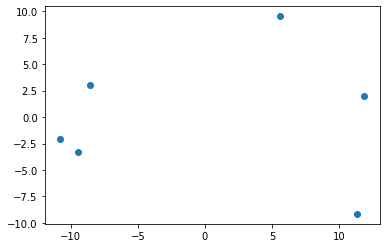

In [5]:
# Visualizing PCA
plt.scatter(components[:,0], components[:,1])

In [6]:
# Clustering 
K = 2
clusters = KMeans(n_clusters=K, random_state=0).fit(components)

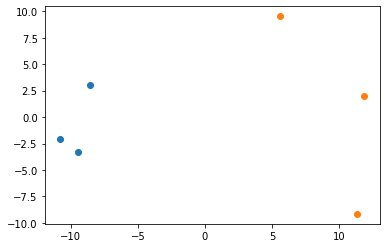

In [7]:
# Visualizing Clusters
for i in range(K):
    labels = clusters.labels_ == i
    plt.scatter(components[labels,0], components[labels,1])

In [28]:
# Printing out different clusters
for i in range(K):
    labels = clusters.labels_ == i
    print('Cluster #:', i)
    for j, article in enumerate(articles[labels]):
        print(j, article)

Cluster #: 0
0 ['Biden sells his old car'
 "President Biden just announced that he is selling is '96 Civic"]
1 ['President Biden to sell car'
 'Biden announced via Twitter that he will indeed be selling his car']
2 ['Biden getting that car cash'
 'Biden is about to cash out once he sells that junker civic!']
Cluster #: 1
0 ['Donald Trump buys a dog' 'Donald Trump recently was found buying a dog']
1 ['President Trump gets a corgie'
 'The White House welcomes a new furry friend, and its name is Evan!']
2 ['U.S. Presidential Paws'
 "You won't believe the new dog that Donald and the fam just got!"]


In [29]:
# Creating the graph
import networkx as nx

G = nx.Graph()

In [ ]:
G.add_nodes_from(['dog','cat'])
G.add_edge('dog','cat')
G.add_edge(1,2)
G.clear()

In [32]:
G.clear()
for art, artv in zip(articles, v):
    root = (art, artv)
    rel = [x for x,y in zip(articles,v) if utils.doc_sim(root[1], y) > .5]

    for art in rel:
        print('root',root[0][0],'comp', art[0])
        G.add_edge(root[0][0], art[0])

root Donald Trump buys a dog comp Donald Trump buys a dog
root Donald Trump buys a dog comp U.S. Presidential Paws
root President Trump gets a corgie comp President Trump gets a corgie
root President Trump gets a corgie comp U.S. Presidential Paws
root U.S. Presidential Paws comp Donald Trump buys a dog
root U.S. Presidential Paws comp President Trump gets a corgie
root U.S. Presidential Paws comp U.S. Presidential Paws
root Biden sells his old car comp Biden sells his old car
root Biden sells his old car comp President Biden to sell car
root Biden sells his old car comp Biden getting that car cash
root President Biden to sell car comp Biden sells his old car
root President Biden to sell car comp President Biden to sell car
root President Biden to sell car comp Biden getting that car cash
root Biden getting that car cash comp Biden sells his old car
root Biden getting that car cash comp President Biden to sell car
root Biden getting that car cash comp Biden getting that car cash


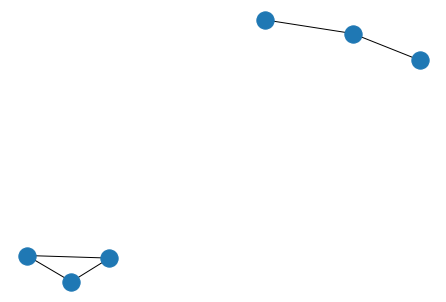

In [33]:
nx.draw(G)

In [34]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(G)

top_level_communities = next(communities_generator)

In [35]:
next_level_communities = next(communities_generator)

sorted(map(sorted, next_level_communities))

[['Biden getting that car cash',
  'Biden sells his old car',
  'President Biden to sell car'],
 ['Donald Trump buys a dog'],
 ['President Trump gets a corgie'],
 ['U.S. Presidential Paws']]

In [36]:
top_level_communities

({'Donald Trump buys a dog'},
 {'President Trump gets a corgie', 'U.S. Presidential Paws'},
 {'Biden getting that car cash',
  'Biden sells his old car',
  'President Biden to sell car'})